In [ ]:
!pip install transformers sentencepiece -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import copy
import torch
from torch import nn

from transformers import (
    XLMRobertaForQuestionAnswering,
    XLMRobertaTokenizerFast,
    XLMRobertaModel,
)
from transformers.models.longformer import LongformerSelfAttention

device = "cuda" if torch.cuda.is_available() else "cpu"

# XLMRobertaLongForQuestionAnswering

`XLMRobertaLongForQuestionAnswering` represents the "long" version of the `XLMRobertaForQuestionAnswering` model. 

It replaces `BertSelfAttention` with `XLMRobertaLongSelfAttention`, which is a thin wrapper around `LongformerSelfAttention`.


In [ ]:
class XLMRobertaLongSelfAttention(LongformerSelfAttention):
    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        """
        :class:`LongformerSelfAttention` expects `len(hidden_states)` to be multiple of `attention_window`. Padding to
        `attention_window` happens in :meth:`LongformerModel.forward` to avoid redoing the padding on each layer.

        Modified LongformerSelfAttention layer to work with RoBERTa models. They have different set of arguments
        compared to original Longformer attention: RoBERTa is passing some additional arguments and arguments required
        by LongformerSelfAttention are missing so we have to add it manually.

        The `attention_mask` is changed in :meth:`LongformerModel.forward` from 0, 1, 2 to:

            * -10000: no attention
            * 0: local attention
            * +10000: global attention
        """
        hidden_states = hidden_states.transpose(0, 1)

        # project hidden states
        query_vectors = self.query(hidden_states)
        key_vectors = self.key(hidden_states)
        value_vectors = self.value(hidden_states)

        ## Lines below has been changed

        attention_mask = attention_mask.squeeze(dim=2).squeeze(dim=1)

        # is index masked or global attention
        is_index_masked = attention_mask < 0
        is_index_global_attn = attention_mask > 0
        is_global_attn = any(is_index_global_attn.flatten())

        ## End of modification

        seq_len, batch_size, embed_dim = hidden_states.size()
        assert (
            embed_dim == self.embed_dim
        ), f"hidden_states should have embed_dim = {self.embed_dim}, but has {embed_dim}"

        # normalize query
        query_vectors /= math.sqrt(self.head_dim)

        query_vectors = query_vectors.view(
            seq_len, batch_size, self.num_heads, self.head_dim
        ).transpose(0, 1)
        key_vectors = key_vectors.view(
            seq_len, batch_size, self.num_heads, self.head_dim
        ).transpose(0, 1)

        attn_scores = self._sliding_chunks_query_key_matmul(
            query_vectors, key_vectors, self.one_sided_attn_window_size
        )

        # values to pad for attention probs

        ## Lines below has been changed

        remove_from_windowed_attention_mask = (
            (attention_mask != 0).unsqueeze(dim=-1).unsqueeze(dim=-1)
        )

        ## End of modification

        # cast to fp32/fp16 then replace 1's with -inf
        float_mask = remove_from_windowed_attention_mask.type_as(
            query_vectors
        ).masked_fill(remove_from_windowed_attention_mask, -10000.0)
        # diagonal mask with zeros everywhere and -inf inplace of padding
        diagonal_mask = self._sliding_chunks_query_key_matmul(
            float_mask.new_ones(size=float_mask.size()),
            float_mask,
            self.one_sided_attn_window_size,
        )

        # pad local attention probs
        attn_scores += diagonal_mask

        assert list(attn_scores.size()) == [
            batch_size,
            seq_len,
            self.num_heads,
            self.one_sided_attn_window_size * 2 + 1,
        ], f"local_attn_probs should be of size ({batch_size}, {seq_len}, {self.num_heads}, {self.one_sided_attn_window_size * 2 + 1}), but is of size {attn_scores.size()}"

        # compute local attention probs from global attention keys and contact over window dim
        if is_global_attn:
            # compute global attn indices required through out forward fn
            (
                max_num_global_attn_indices,
                is_index_global_attn_nonzero,
                is_local_index_global_attn_nonzero,
                is_local_index_no_global_attn_nonzero,
            ) = self._get_global_attn_indices(is_index_global_attn)
            # calculate global attn probs from global key

            global_key_attn_scores = self._concat_with_global_key_attn_probs(
                query_vectors=query_vectors,
                key_vectors=key_vectors,
                max_num_global_attn_indices=max_num_global_attn_indices,
                is_index_global_attn_nonzero=is_index_global_attn_nonzero,
                is_local_index_global_attn_nonzero=is_local_index_global_attn_nonzero,
                is_local_index_no_global_attn_nonzero=is_local_index_no_global_attn_nonzero,
            )
            # concat to local_attn_probs
            # (batch_size, seq_len, num_heads, extra attention count + 2*window+1)
            attn_scores = torch.cat((global_key_attn_scores, attn_scores), dim=-1)

            # free memory
            del global_key_attn_scores

        attn_probs = F.softmax(
            attn_scores, dim=-1, dtype=torch.float32
        )  # use fp32 for numerical stability

        # softmax sometimes inserts NaN if all positions are masked, replace them with 0
        attn_probs = torch.masked_fill(
            attn_probs, is_index_masked[:, :, None, None], 0.0
        )
        attn_probs = attn_probs.type_as(attn_scores)

        # free memory
        del attn_scores

        # apply dropout
        attn_probs = F.dropout(attn_probs, p=self.dropout, training=self.training)

        value_vectors = value_vectors.view(
            seq_len, batch_size, self.num_heads, self.head_dim
        ).transpose(0, 1)

        # compute local attention output with global attention value and add
        if is_global_attn:
            # compute sum of global and local attn
            attn_output = self._compute_attn_output_with_global_indices(
                value_vectors=value_vectors,
                attn_probs=attn_probs,
                max_num_global_attn_indices=max_num_global_attn_indices,
                is_index_global_attn_nonzero=is_index_global_attn_nonzero,
                is_local_index_global_attn_nonzero=is_local_index_global_attn_nonzero,
            )
        else:
            # compute local attn only
            attn_output = self._sliding_chunks_matmul_attn_probs_value(
                attn_probs, value_vectors, self.one_sided_attn_window_size
            )

        assert attn_output.size() == (
            batch_size,
            seq_len,
            self.num_heads,
            self.head_dim,
        ), "Unexpected size"
        attn_output = (
            attn_output.transpose(0, 1)
            .reshape(seq_len, batch_size, embed_dim)
            .contiguous()
        )

        # compute value for global attention and overwrite to attention output
        # TODO: remove the redundant computation
        if is_global_attn:
            (
                global_attn_output,
                global_attn_probs,
            ) = self._compute_global_attn_output_from_hidden(
                hidden_states=hidden_states,
                max_num_global_attn_indices=max_num_global_attn_indices,
                is_local_index_global_attn_nonzero=is_local_index_global_attn_nonzero,
                is_index_global_attn_nonzero=is_index_global_attn_nonzero,
                is_local_index_no_global_attn_nonzero=is_local_index_no_global_attn_nonzero,
                is_index_masked=is_index_masked,
            )

            # get only non zero global attn output
            nonzero_global_attn_output = global_attn_output[
                is_local_index_global_attn_nonzero[0],
                :,
                is_local_index_global_attn_nonzero[1],
            ]

            # overwrite values with global attention
            attn_output[
                is_index_global_attn_nonzero[::-1]
            ] = nonzero_global_attn_output.view(
                len(is_local_index_global_attn_nonzero[0]), -1
            )
            # The attention weights for tokens with global attention are
            # just filler values, they were never used to compute the output.
            # Fill with 0 now, the correct values are in 'global_attn_probs'.
            attn_probs[is_index_global_attn_nonzero] = 0

        outputs = (attn_output.transpose(0, 1),)

        if output_attentions:
            outputs += (attn_probs,)

        return (
            outputs + (global_attn_probs,)
            if (is_global_attn and output_attentions)
            else outputs
        )


class XLMRobertaLongForQuestionAnswering(XLMRobertaForQuestionAnswering):
    def __init__(self, config):
        super().__init__(config)
        for i, layer in enumerate(self.roberta.encoder.layer):
            # replace the `modeling_xlmroberta.XLMRobertaAttention` object with `XLMRobertaLongSelfAttention`
            layer.attention.self = XLMRobertaLongSelfAttention(config, layer_id=i)

Starting from the `roberta-base` checkpoint, the following function converts it into an instance of `RobertaLong`. It makes the following changes:

- extend the position embeddings from `512` positions to `max_pos`. In Longformer, we set `max_pos=4096`
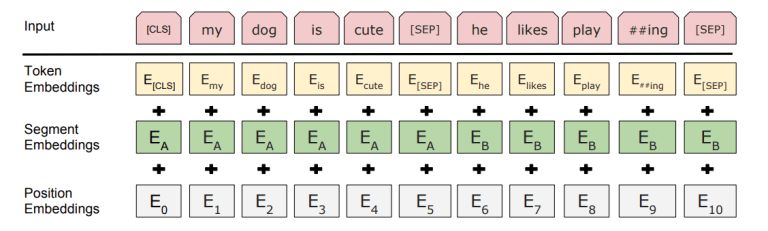
- initialize the additional position embeddings by copying the embeddings of the first `512` positions. This initialization is crucial for the model performance (check table 6 in [the paper](https://arxiv.org/pdf/2004.05150.pdf) for performance without this initialization)

- replaces `BertSelfAttention` objects with `LongformerSelfAttention` with a attention window size `attention_window`

The output of this function works for long documents even without pretraining. Check tables 6 and 11 in [the paper](https://arxiv.org/pdf/2004.05150.pdf) to get a sense of the expected performance of this model before pretraining.

# Conversion

In [ ]:
model_name = "deepset/xlm-roberta-base-squad2"
attention_window = 256  # 512
max_pos = 4096  # 512 * 8


model = XLMRobertaForQuestionAnswering.from_pretrained(
    model_name, gradient_checkpointing=True
)
tokenizer = XLMRobertaTokenizerFast.from_pretrained(
    model_name, model_max_length=max_pos
)
config = model.config

In [ ]:
# extend position embeddings of the tokenizer
tokenizer.model_max_length = max_pos
tokenizer.init_kwargs["model_max_length"] = max_pos
current_max_pos, embed_size = model.roberta.embeddings.position_embeddings.weight.shape

In [ ]:
max_pos += (
    2  # NOTE: RoBERTa has positions 0,1 reserved, so embedding size is max position + 2
)
config.max_position_embeddings = max_pos
assert max_pos > current_max_pos

# allocate a larger position embedding matrix
new_pos_embed = model.roberta.embeddings.position_embeddings.weight.new_zeros(
    max_pos, embed_size
)

# copy position embeddings over and over to initialize the new position embeddings
k = 2
step = current_max_pos - 2
while k < max_pos - 1:
    new_pos_embed[k : (k + step)] = model.roberta.embeddings.position_embeddings.weight[
        2:
    ]
    k += step
model.roberta.embeddings.position_embeddings.weight.data = new_pos_embed
model.roberta.embeddings.position_embeddings.num_embeddings = len(new_pos_embed.data)

num_model_embeddings = model.roberta.embeddings.position_embeddings.num_embeddings
model.roberta.embeddings.position_ids = torch.arange(0, num_model_embeddings)[None]

model.roberta.embeddings.position_ids.data = torch.tensor(
    [i for i in range(max_pos)]
).reshape(1, max_pos)

In [ ]:
# replace the `modeling_bert.BertSelfAttention` object with `LongformerSelfAttention`
config.attention_window = [attention_window] * config.num_hidden_layers

for i, layer in enumerate(model.roberta.encoder.layer):
    longformer_self_attn = XLMRobertaLongSelfAttention(config, layer_id=i)
    longformer_self_attn.query = copy.deepcopy(layer.attention.self.query)
    longformer_self_attn.key = copy.deepcopy(layer.attention.self.key)
    longformer_self_attn.value = copy.deepcopy(layer.attention.self.value)

    longformer_self_attn.query_global = copy.deepcopy(layer.attention.self.query)
    longformer_self_attn.key_global = copy.deepcopy(layer.attention.self.key)
    longformer_self_attn.value_global = copy.deepcopy(layer.attention.self.value)

    layer.attention.self = longformer_self_attn

In [ ]:
config.attention_window, len(config.attention_window)

([256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256], 12)

In [ ]:
model.roberta.encoder.layer[-1]

XLMRobertaLayer(
  (attention): XLMRobertaAttention(
    (self): XLMRobertaLongSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (query_global): Linear(in_features=768, out_features=768, bias=True)
      (key_global): Linear(in_features=768, out_features=768, bias=True)
      (value_global): Linear(in_features=768, out_features=768, bias=True)
    )
    (output): XLMRobertaSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): XLMRobertaIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): XLMRobertaOutput(
    (dense): Linear(in_features=3072, out_features=768

In [ ]:
save_model_to = (
    "/content/drive/MyDrive/XLMRobertaLongForQuestionAnswering-base-squad2-256-4096"
)
print(f"saving model to {save_model_to}")
model.save_pretrained(save_model_to)
tokenizer.save_pretrained(save_model_to)

saving model to /content/drive/MyDrive/XLMRobertaLongForQuestionAnswering-base-squad2-256-4096


('/content/drive/MyDrive/XLMRobertaLongForQuestionAnswering-base-squad2-256-4096/tokenizer_config.json',
 '/content/drive/MyDrive/XLMRobertaLongForQuestionAnswering-base-squad2-256-4096/special_tokens_map.json',
 '/content/drive/MyDrive/XLMRobertaLongForQuestionAnswering-base-squad2-256-4096/sentencepiece.bpe.model',
 '/content/drive/MyDrive/XLMRobertaLongForQuestionAnswering-base-squad2-256-4096/added_tokens.json',
 '/content/drive/MyDrive/XLMRobertaLongForQuestionAnswering-base-squad2-256-4096/tokenizer.json')

# XLMRobertaLongForQuestionAnswering

In [ ]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained(
    save_model_to, model_max_length=4096
)
xlm_roberta = XLMRobertaLongForQuestionAnswering.from_pretrained(
    save_model_to, max_length=4096
).to(device)

In [ ]:
xlm_roberta.roberta.embeddings.position_embeddings

Embedding(4098, 768, padding_idx=1)

In [ ]:
question = "What hourglass-shaped women's garment was made using whalebone?"
long_context = """
Baleen is a filter-feeder system inside the mouths of baleen whales. The baleen system works when a whale opens its mouth underwater and the whale takes in water. The whale then pushes the water out, and animals such as krill are filtered by the baleen and remain as food source for the whale. Baleen is similar to bristles and is made of keratin, the same substance found in human fingernails and hair. Some whales, such as the bowhead whale, have longer baleen than others. Other whales, such as the gray whale, only use one side of their baleen. These baleen bristles are arranged in plates across the upper jaw of the whale. Baleen is often called whalebone, but that name also can refer to the normal bones of whales, which have often been used as a material, especially as a cheaper substitute for ivory in carving. Depending on the species, a baleen plate can be long, and weigh up to . Its hairy fringes are called baleen hair or whalebone-hair. They are also called baleen bristles, which in sei whales are highly calcified, calcification functioning to increase their stiffness. Baleen plates are broader at the gumline (base). The plates have been compared to sieves or Venetian blinds. Etymology The word baleen derives from the Latin bālaena, related to the Greek phalaina – both of which mean "whale". Evolution The oldest true fossils of baleen are only 15 million years old, but baleen rarely fossilizes, and scientists believe it originated considerably earlier than that. This is indicated by baleen-related skull modifications being found in fossils from considerably earlier, including a buttress of bone in the upper jaw beneath the eyes, and loose lower jaw bones at the chin. Baleen is believed to have evolved around thirty million years ago, possibly from a hard, gummy upper jaw, like the one a Dall's porpoise has; it closely resembles baleen at the microscopic level. The initial evolution and radiation of baleen plates is believed to have occurred during Early Oligocene when Antarctica broke off from Gondwana and the Antarctic Circumpolar Current was formed, increasing productivity of ocean environments. This occurred because the current kept warm ocean waters away from the area that is now Antarctica, producing steep gradients in temperature, salinity, light, and nutrients where the warm water meets the cold. The transition from teeth to baleen is proposed to have occurred stepwise, from teeth to a hybrid to baleen. It is known that modern mysticetes have teeth initially and then develop baleen plate germs in utero, but lose their dentition and have only baleen during juvenile and adulthood. However, developing mysticetes do not produce tooth enamel because at some point this trait evolved to become a pseudogene. This is likely to have occurred about 28 million years ago and proves that dentition is an ancestral state of mysticetes. Using parsimony to study this and other ancestral characters suggest that the common ancestor of aetiocetids and edentulous mysticetes evolved lateral nutrient foramina, which are believed to have provided blood vessels and nerves a way to reach developing baleen. Further research suggests that the baleen of Aetiocetus was arranged in bundles between widely spaced teeth. If true, this combination of baleen and dentition in Aetiocetus would act as a transition state between odontocetes and mysticetes. This intermediate step is further supported by evidence of other changes that occurred with the evolution of baleen that make it possible for the organisms to survive using filter feeding, such as a change in skull structure and throat elasticity. It would be highly unlikely for all of these changes to occur at once. Therefore, it is proposed that Oligocene aetiocetids possess both ancestral and descendent character states regarding feeding strategies. This makes them mosaic taxa, showing that either baleen evolved before dentition was lost or that the traits for filter feeding originally evolved for other functions. It also shows that the evolution could have occurred gradually because the ancestral state was originally maintained. Therefore, the mosaic whales could have exploited new resources using filter feeding while not abandoning their previous prey strategies. The result of this stepwise transition is apparent in modern-day baleen whales, because of their enamel pseudogenes and their in utero development and reabsorbing of teeth. If it is true that many early baleen whales also had teeth, these were probably used only peripherally, or perhaps not at all (again like Dall's porpoise, which catches squid and fish by gripping them against its hard upper jaw). Intense research has been carried out to sort out the evolution and phylogenetic history of mysticetes, but there is still much debate surrounding this issue. More work needs to be done to characterize extinct ancestral fossils so that future scientists will be able to piece together a more accurate phylogenetic tree. Filter feeding A whale's baleen plates play the most important role in its filter-feeding process. In order to feed, a baleen whale opens its mouth widely and scoops in dense shoals of prey (such as krill, copepods, small fish and sometimes birds that happen to be near the shoals), together with large volumes of water. It then partly shuts its mouth and presses its tongue against its upper jaw, forcing the water to pass out sideways through the baleen, thus sieving out the prey which it then swallows. Human uses People formerly used baleen (usually referred to as "whalebone") for making numerous items where flexibility and strength were required, including backscratchers, collar stiffeners, buggy whips, parasol ribs, crinoline petticoats and corset stays. It was commonly used to crease paper; its flexibility kept it from damaging the paper. It was also occasionally used in cable-backed bows. Synthetic materials are now usually used for similar purposes, especially plastic and fibre glass. It is not to be confused with whale's bone meaning the bones of whales, used in carving, for cutlery handles and other uses for the bones of various large species. As a habitat Baleen serves as a habitat for some species from the gastropod families Pyropeltidae, Cocculinidae, Osteopeltidae and Neolepetopsidae.
"""

In [ ]:
question = "Which name is also used to describe the Amazon rainforest in English?"
long_context = """
The Amazon rainforest (Portuguese: Floresta Amazônica or Amazônia; Spanish: Selva Amazónica, Amazonía or usually Amazonia; French: Forêt amazonienne; Dutch: Amazoneregenwoud), also known in English as Amazonia or the Amazon Jungle, is a moist broadleaf forest that covers most of the Amazon basin of South America. This basin encompasses 7,000,000 square kilometres (2,700,000 sq mi), of which 5,500,000 square kilometres (2,100,000 sq mi) are covered by the rainforest. This region includes territory belonging to nine nations. The majority of the forest is contained within Brazil, with 60% of the rainforest, followed by Peru with 13%, Colombia with 10%, and with minor amounts in Venezuela, Ecuador, Bolivia, Guyana, Suriname and French Guiana. States or departments in four nations contain "Amazonas" in their names. The Amazon represents over half of the planet's remaining rainforests, and comprises the largest and most biodiverse tract of tropical rainforest in the world, with an estimated 390 billion individual trees divided into 16,000 species.
"""

In [ ]:
question = "¿Qué otro nombre se utiliza para describir la selva amazónica?"
long_context = """
La selva amazónica (portugués: Floresta Amazônica o Amazônia; español: Selva Amazónica, Amazonía o normalmente Amazonia; francés: Forêt amazonienne; neerlandés: Amazoneregenwoud), también conocida en inglés como Amazonia o the Amazon Jungle, es un bosque latifoliado húmedo que cubre la mayor parte de la cuenca amazónica de Sudamérica. Esta cuenca abarca 7.000.000 kilómetros cuadrados (2.700.000 millas cuadradas), de los cuales 5.500.000 kilómetros cuadrados (2.100.000 millas cuadradas) están cubiertos por la selva tropical. Esta región incluye territorios pertenecientes a nueve naciones. La mayor parte de la selva se encuentra en Brasil, con un 60%, seguido de Perú, con un 13%, Colombia, con un 10%, y con pequeñas extensiones en Venezuela, Ecuador, Bolivia, Guyana, Surinam y la Guayana Francesa. Estados o departamentos de cuatro naciones contienen "Amazonas" en sus nombres. La Amazonia representa más de la mitad de las selvas tropicales que quedan en el planeta, y comprende la mayor y más biodiversa extensión de selva tropical del mundo, con unos 390.000 millones de árboles divididos en 16.000 especies.
"""

In [ ]:
question = "which GPU are they evaluate with?"
long_context = """
We evaluate on text8 and enwik8, both contain 100M characters from Wikipedia split into 90M, 5M, 5M for train, dev, test. Our model only specifies how the self-attention component works, and it is agnostic to the other design choices for the transformer model. Our implementation is based on the Transformer-XL (Dai et al., 2019) code11 with the memory mechanism disabled. We use relative position embeddings with sinusoidal weights as in Dai et al. (2019). We use two different model sizes, a experiments on 48GB RTX8000 GPUs. All hyperparameters and stage configurations are listed in Tab. 12. Our CUDA kernel supports the autoregressive mode where each token attends to a window of previous tokens only. Our implementation also includes a version of the relative position embedding that is compatible with our dilated sliding window attention. We ran the small model experiments on 4 RTX8000 GPUs for 16 days. For the large model, we ran experiments on 8 RTX8000 GPUs for 13 days. Most of our hyperparameter search is similarto the ablation in Tab. 4 where we run the configuration for 150K steps on text8. We experimented with absolute position embeddings and learned position embeddings, dropout values of [0.1, 0.2] (small model) and [0.1, 0.4] (large model), prelayernorm and post-layernorm (Xiong et al., 2020), learning rate (LR) of phase1 of values [2.5e-5, 5e4, 1e-4] constant and cosine LR schedules, and different configurations for dilation (on all heads, on 2 heads, no dilation). Number of gradient updates/phase reported in Tab. 12 is determined by running each phase until the validation BPC stops
"""

In [ ]:
len(tokenizer(question, long_context, return_tensors="pt")["input_ids"][0])

1584

In [ ]:
inputs = tokenizer(
    question, long_context, max_length=4096, padding="max_length", return_tensors="pt"
)

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
with torch.no_grad():
    out = xlm_roberta(input_ids, attention_mask)

start_index = torch.argmax(out[0])
end_index = torch.argmax(out[1])
start_index, end_index

(tensor(75, device='cuda:0'), tensor(81, device='cuda:0'))

In [ ]:
out.start_logits.shape

torch.Size([1, 4096])

In [ ]:
tokenizer.decode(input_ids[0][start_index : end_index + 1])

'text8 and enwik8'

In [ ]:
input_ids.shape

torch.Size([1, 4096])

In [ ]:
torch.cuda.empty_cache()